In [560]:
# compare SMP derived values to Gaia
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astroquery.simbad import Simbad


gaia_data =  pd.read_csv('./gaia_properties.csv') # gaia stellar properties (only R and Teff)
apf_data = pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/SM_steller_properties/specmatch_results_all_apf.csv') # SM-Emp values derived from APF spectra
#apf_data_detrended = pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/SM_steller_properties/specmatch_results_detrended.csv') # SM-Emp values derived from APF spectra, detrended in run_smemp_apf.ipynb
hires_data = pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/lincomb_results_detrend.csv') # SM-Emp values derived from HIRES spectra (detrended)
yee_data = pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/yee_library_full.csv') # library values
SNR_data = pd.read_csv('./all_apf_highest_SNRs.csv')

In [431]:
# find HIP names of each star in order to compare the same stars
def get_HIPname(name):
    if name.startswith('HIP'):
            HIP_name = name
    else:      
        try:
            result_table = Simbad.query_objectids(name)
            alt_names = result_table.to_pandas()
            alt_names = alt_names.iloc[:,0].str.decode('utf-8') #gets rid of weird formatting
            HIP_name = alt_names[alt_names.str.contains("HIP")]
            if len(HIP_name) == 0:
                HIP_name = 'None'
                print(name + ' has no HIP name in SIMBAD') #this should never occur since only using stars with HIP names for finding overlap between apf and Yee
            elif len(HIP_name) == 1:
                HIP_name = str(HIP_name.iloc[0]) # makes it a string instead of dataframe with one cell  
            else:
                print('more than one HIP name found for ' + name)
        except AttributeError:
            HIP_name = 'None'
            print(name + ': SIMBAD search error (likely \'No known catalog could be found\' or \'this identifier has an incorrect format for catalog\'') # should not happen
    return HIP_name


In [ ]:
# process names in file so be searchable by Simbad (move this logic to inside get_HIPname loop to speed up!)
for row in range(len(apf_data)):
    name = apf_data.iloc[row,0]
    if name[0].isdigit():
        apf_data.iloc[row,0] = 'HD' + name
    elif name.startswith('K0'):
        apf_data.iloc[row,0] = 'KOI-' + name[1:]
    elif name.startswith('EPIC-'):
        apf_data.iloc[row,0] = 'EPIC' + name[5:]
    elif name.startswith('<Park>'):
        apf_data.drop(row)
        
        

# process names in file so be searchable by Simbad (move this logic to inside get_HIPname loop to speed up!)
#for row in range(len(apf_data_detrended)):
#    name = apf_data_detrended.iloc[row,0]
#    if name[0].isdigit():
#        apf_data_detrended.iloc[row,0] = 'HD' + name
#    elif name.startswith('K0'):
#        apf_data_detrended.iloc[row,0] = 'KOI-' + name[1:]
#    elif name.startswith('EPIC-'):
#        apf_data_detrended.iloc[row,0] = 'EPIC' + name[5:]       
        
# sort by HIP name of stars for easy comparison
apf_HIP = apf_data
for row in range(len(apf_data)):
    apf_HIP.iloc[row,0] = get_HIPname(apf_data.iloc[row,0]).replace(' ','')
apf_HIP.rename(columns = {'apf_name':'HIP_name'}, inplace = True)
apf_sorted = apf_HIP.sort_values(by=['HIP_name'])
drop_rows = apf_sorted.index[apf_sorted['HIP_name'] == 'None']
apf_sorted = apf_sorted.drop(drop_rows)
apf_sorted = apf_sorted.drop_duplicates(subset=['HIP_name'], keep='first') # drop repeats -- maybe better to average or something?
apf_sorted = apf_sorted.reset_index(drop=True)

gaia_HIP = gaia_data
for row in range(len(gaia_data)): # rename by HIP name
    gaia_HIP.iloc[row,6] = get_HIPname(gaia_data.iloc[row,6]).replace(' ','')  
gaia_HIP.rename(columns = {'target_id':'HIP_name'}, inplace = True)
gaia_sorted = pd.DataFrame(columns = gaia_HIP.columns) # empty for now
num_rows = 0; num_gaia_rows = 0; num_gaia_rows_after_drop = 0 # for testing
for row in range(len(apf_sorted)): # populate by apf row
    HIP_name = apf_sorted.iloc[row,0]
    print(HIP_name + ': ')
    gaia_row = gaia_HIP[gaia_HIP['HIP_name'] == HIP_name]
    if gaia_row.empty:
        gaia_row  = pd.Series([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan], index=gaia_HIP.columns.values.tolist())
        gaia_row['HIP_name'] = HIP_name
    if len(gaia_row) > 1 and len(gaia_row) != 15: # NOTE: if there is only one row len(gaia_row) returns 15 (the number of cols)
        gaia_row = gaia_row.iloc[0,:]
    print('    gaia names ' + str(gaia_row['HIP_name']))
    num_gaia_rows += 1
    num_rows += 1
    gaia_sorted = gaia_sorted.append(gaia_row, ignore_index=True)
gaia_sorted = gaia_sorted.drop_duplicates(subset=['HIP_name'], keep='first') # drop repeats -- maybe better to average or something?


'''
yee_HIP = yee_data
drop_rows = []
for row in range(len(yee_data)):
    yee_HIP.iloc[row,0] = get_HIPname(yee_data.iloc[row,0]).replace(' ','')  
    if not(apf_sorted["HIP_name"].str.contains(yee_HIP.iloc[row,0]).any()):
        drop_rows = drop_rows + [row]
yee_HIP = yee_HIP.drop(drop_rows)
yee_HIP.rename(columns = {'Name':'HIP_name'}, inplace = True)
yee_sorted = yee_HIP.sort_values(by=['HIP_name'])

hires_HIP = hires_data
drop_rows = []
for row in range(len(hires_data)):
    hires_HIP.iloc[row,4] = get_HIPname(hires_data.iloc[row,4]).replace(' ','')  
    if not(apf_sorted["HIP_name"].str.contains(hires_HIP.iloc[row,4]).any()):
        drop_rows = drop_rows + [row]
hires_HIP = hires_HIP.drop(drop_rows)
hires_HIP.rename(columns = {'source_name':'HIP_name'}, inplace = True)
hires_sorted = hires_HIP.sort_values(by=['HIP_name'])

#apf_det_HIP = apf_data_detrended
#for row in range(len(apf_data_detrended)):
#    apf_det_HIP.iloc[row,0] = get_HIPname(apf_data_detrended.iloc[row,0]).replace(' ','')
#apf_det_HIP.rename(columns = {'apf_name':'HIP_name'}, inplace = True)
#apf_det_sorted = apf_det_HIP.sort_values(by=['HIP_name'])


gaia_HIP = gaia_data
drop_rows = []
gaia_dropped = []
for row in range(len(gaia_data)):
    gaia_HIP.iloc[row,6] = get_HIPname(gaia_data.iloc[row,6]).replace(' ','')  
    if not(apf_sorted["HIP_name"].str.contains(gaia_HIP.iloc[row,6]).any()): # For now, since only have calibration set to compare to
        drop_rows = drop_rows + [row]
        gaia_dropped += [gaia_HIP.iloc[row,6]]
gaia_HIP = gaia_HIP.drop(drop_rows)
gaia_HIP.rename(columns = {'target_id':'HIP_name'}, inplace = True)
for row in range(len(apf_sorted.iloc[:,0])): # do this so that rows correspond across dataframs correctly even with lots of nans
    name = apf_sorted['HIP_name'][row]
    if not(gaia_HIP['HIP_name'].str.contains(name).any()):
        row  = pd.Series([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan], index=gaia_HIP.columns.values.tolist())
        row['HIP_name'] = name
        gaia_HIP = gaia_HIP.append(row, ignore_index=True)
gaia_sorted = gaia_HIP.sort_values(by=['HIP_name'])    
gaia_sorted = gaia_sorted.drop_duplicates(subset=['HIP_name'], keep='first') # drop repeats -- maybe better to average or something?
'''

In [558]:
# just this once
gaia_HIP.to_csv('./Gaia_properties_by_HIP_name.csv')

In [215]:
num_rows
num_gaia_rows

6548

In [423]:
#apf_Teff = apf_sorted.iloc[:,2].to_numpy() 
apf_Teff = apf_sorted['Teff'].to_numpy() 
yee_Teff = yee_sorted.iloc[:,1].to_numpy()
hires_Teff = hires_sorted.iloc[:,86].to_numpy()
apf_det_Teff = apf_sorted['Teff_detrended'].to_numpy() 
gaia_Teff = gaia_sorted.iloc[:,4].to_numpy() 
apf_R = apf_sorted['radius'].to_numpy() 
yee_R = yee_sorted.iloc[:,3].to_numpy()
hires_R = hires_sorted.iloc[:,89].to_numpy()
apf_det_R = apf_sorted['radius_detrended'].to_numpy() 
gaia_R = gaia_sorted.iloc[:,5].to_numpy() 
apf_feh = apf_sorted['feh'].to_numpy() 
yee_feh = yee_sorted.iloc[:,7].to_numpy()
hires_feh = hires_sorted.iloc[:,95].to_numpy()
apf_det_feh = apf_sorted['feh_detrended'].to_numpy() 
apf_det_R_err = apf_sorted['u_radius_detrended'].to_numpy() 
apf_det_Teff_err = apf_sorted['u_Teff_detrended'].to_numpy() 

HIP_names = apf_sorted['HIP_name']

gaia_Teff_err = 324 # K
gaia_R_err_pcnt = 0.10 # percent!!

In [424]:
len(np.where((np.isnan(gaia_R)))[0]) # 477
len(np.where((np.isnan(gaia_Teff)))[0]) # 385
both = ((np.isnan(gaia_R))*(np.isnan(gaia_Teff))) 
len(np.where(both)[0]) # 385 --> so all stars with Nan Teff also have Nan R

385

Overall RMS: 
   Teff: 681.235
   R: 1.833
Within Teff library region RMS: 
   Teff: 383.739
Within R library region RMS: 
   R: 1.545
Within Teff library region and no Nan gaia radii RMS: 
   Teff: 255.053
Within R library region and no Nan gaia Teff RMS: 
   R: 1.545


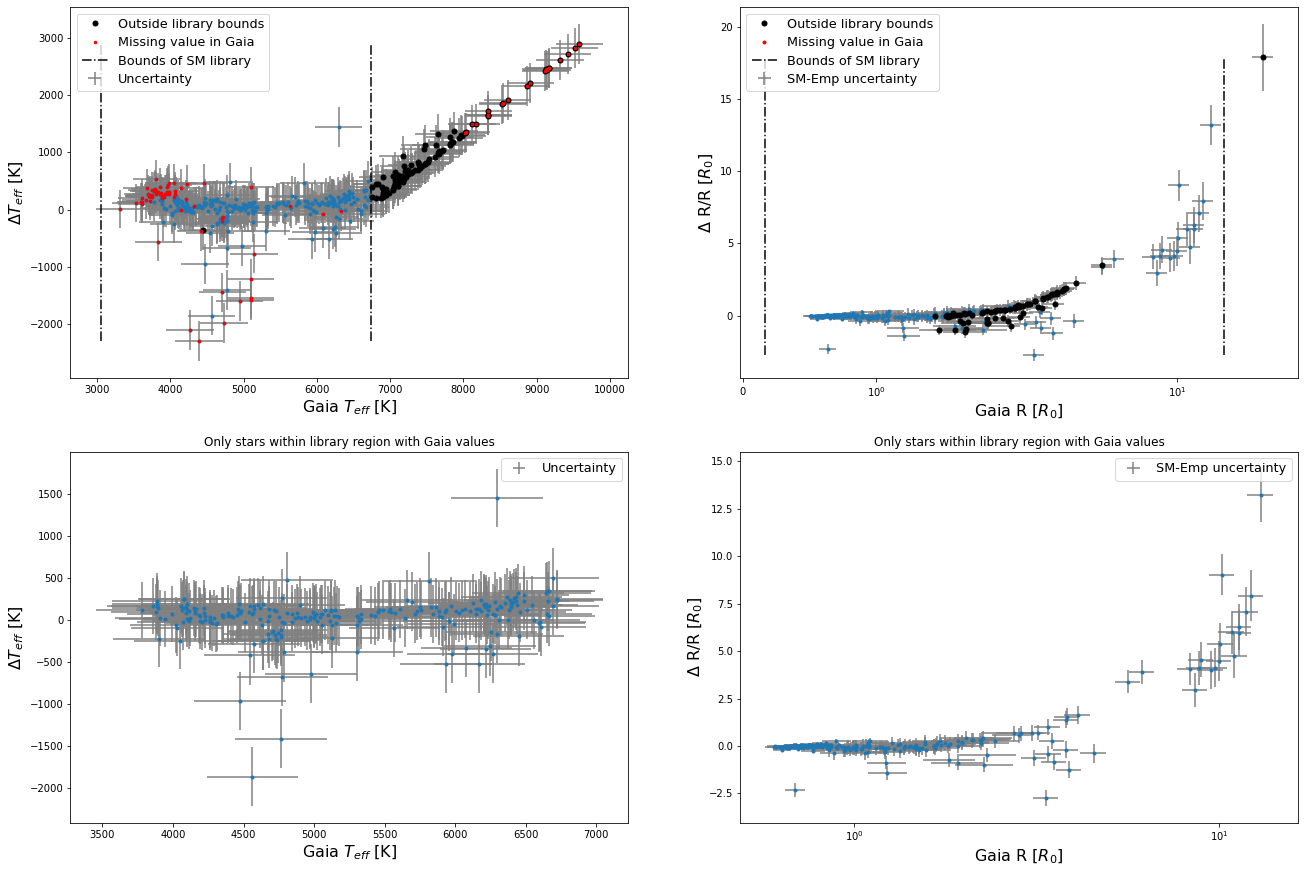

In [643]:
not_nan_apf = np.invert((np.isnan(apf_Teff))) # all values for a star will be Nan if SM-Emp failed for that star.
not_nan_gaia_T = np.invert((np.isnan(gaia_Teff)))
not_nan_gaia_R = np.invert((np.isnan(gaia_R)))
not_nan_gaia = not_nan_gaia_R*not_nan_gaia_T # Some Gaia values are Nan even if the star exists in the cataloge
nan_gaia = np.logical_or(np.isnan(gaia_Teff), np.isnan(gaia_R))
in_lib_region_R = (gaia_R > 0.168)*(gaia_R < 15.781)*not_nan_gaia_R
in_lib_region_Teff = (gaia_Teff > 3056)*(gaia_Teff < 6738)*not_nan_gaia_T
not_in_lib_region = np.logical_or(not_nan_gaia_T*np.invert(in_lib_region_Teff), not_nan_gaia_R*np.invert(in_lib_region_R))


diff_R = gaia_R - apf_det_R
diff_T = gaia_Teff- apf_det_Teff
fs = 16

def make_plots(scale, plot_num, which_plot):
    if which_plot == 'all':
        subset = not_nan_apf
    if which_plot == 'subset':
        subset = not_nan_apf*in_lib_region_R*in_lib_region_Teff*np.invert(nan_gaia)
    plt.subplot(2,2,plot_num)
    plt.errorbar(gaia_Teff[subset], diff_T[subset], 
                 yerr = np.sqrt(apf_det_Teff_err[subset]**2 + 324**2), xerr = 324, 
                 ls = 'None', color = 'gray', label = 'Uncertainty')
    plt.plot(gaia_Teff[subset], diff_T[subset],'.')
    if which_plot == 'all':
        plt.vlines([3056, 6738], ymin = np.nanmin(diff_T[not_nan_apf]), ymax = np.nanmax(diff_T[not_nan_apf]), ls = '-.',  label = 'Bounds of SM library')
        plt.plot(gaia_Teff[not_nan_apf*not_in_lib_region], diff_T[not_nan_apf*not_in_lib_region ],'.', markersize = 10, color = 'black', alpha = 1, label = 'Outside library bounds')    
        plt.plot(gaia_Teff[nan_gaia], diff_T[nan_gaia],'.', markersize = 5, color = 'red', alpha = 1, label = 'Missing value in Gaia')
        plt.plot(gaia_Teff[np.isnan(gaia_R)], diff_T[np.isnan(gaia_R)],'.', markersize = 3, color = 'red')
    else: plt.title('Only stars within library region with Gaia values')
    plt.ylabel('$\Delta T_{eff}$ [K]', fontsize = fs)
    plt.xlabel('Gaia $T_{eff}$ [K]', fontsize = fs)
    if scale == 'log':
        plt.yscale('symlog')
    plt.legend(fontsize = 0.8*fs)
    plt.subplot(2,2,1 + plot_num)
    plt.errorbar(gaia_R[subset], diff_R[subset], 
         yerr = np.sqrt(apf_det_R_err[subset]**2 + (0.10*gaia_R[subset])**2), xerr = 0.10*gaia_R[subset], 
         ls = 'None', color = 'gray',  label = 'SM-Emp uncertainty')
    plt.plot(gaia_R[subset], diff_R[subset],'.')
    if which_plot == 'all':
        plt.vlines([0.168, 15.781], ymin = np.nanmin(diff_R[not_nan_apf]), ymax = np.nanmax(gaia_R[not_nan_apf] - apf_det_R[not_nan_apf]), ls = '-.',  label = 'Bounds of SM library')
        plt.plot(gaia_R[not_nan_apf*not_in_lib_region], diff_R[not_nan_apf*not_in_lib_region],'.', markersize = 10, color = 'black', alpha = 1.0, label = 'Outside library bounds')   
        plt.plot(gaia_R[nan_gaia], diff_R[nan_gaia],'.', color = 'red', alpha = 1, label = 'Missing value in Gaia')
        #plt.vlines([7.8], ymin = np.nanmin(diff_R[not_nan_apf]), ymax = np.nanmax(gaia_R[not_nan_apf] - apf_det_R[not_nan_apf]), ls = '-.',  color = 'gray', label = '(One library star R = 15)')
    else: plt.title('Only stars within library region with Gaia values')
    plt.ylabel('$\Delta$ R/R [$R_0$]', fontsize = fs)
    plt.xlabel('Gaia R [$R_0$]', fontsize = fs)
    #plt.ylim([-5,5])
    #plt.xlim([0,5])
    #if scale == 'log':
    plt.xscale('symlog')
    plt.legend(fontsize = 0.8*fs)
    
plt.figure(figsize = [22,15])
make_plots('linear', 1, 'all')
make_plots('linear', 3, 'subset')
#make_plots('log', 3)

# Calculate RMS
RMS_overall_Teff = np.sqrt(np.nanmean(diff_T**2))
RMS_overall_R= np.sqrt(np.nanmean(diff_R**2))
RMS_lib_region_Teff = np.sqrt(np.nanmean(diff_T[in_lib_region_Teff]**2))
RMS_lib_region_R= np.sqrt(np.nanmean(diff_R[in_lib_region_R]**2))
RMS_lib_region_no_nan_Teff = np.sqrt(np.nanmean(diff_T[in_lib_region_Teff*np.invert(nan_gaia)]**2))
RMS_lib_region_no_nan_R= np.sqrt(np.nanmean(diff_R[in_lib_region_R*np.invert(nan_gaia)]**2))
print('Overall RMS: ')
print('   Teff: ' + str(np.round(RMS_overall_Teff,3)))
print('   R: ' + str(np.round(RMS_overall_R,3)))
print('Within Teff library region RMS: ')
print('   Teff: ' + str(np.round(RMS_lib_region_Teff,3)))
print('Within R library region RMS: ')
print('   R: ' + str(np.round(RMS_lib_region_R,3)))
print('Within Teff library region and no Nan gaia radii RMS: ')
print('   Teff: ' + str(np.round(RMS_lib_region_no_nan_Teff,3)))
print('Within R library region and no Nan gaia Teff RMS: ')
print('   R: ' + str(np.round(RMS_lib_region_no_nan_R,3)))

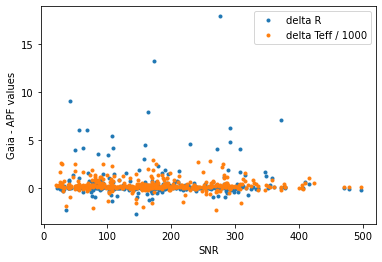

In [584]:
# Inspect outliers

diff_R = gaia_R - apf_det_R
diff_T = gaia_Teff- apf_det_Teff
names = HIP_names

R_outlier_names = names[(np.abs(diff_T) > 1000)*in_lib_region_R*in_lib_region_Teff*not_nan_gaia]
T_outlier_names = names[(np.abs(diff_R) > 1)*in_lib_region_R*in_lib_region_Teff*np.invert(nan_gaia)]

SNR = []
SNR_names = []
for idx in range(len(names)):
    name = names.iloc[idx]
    SNR_names += [SNR_data[SNR_data['HIP_name'] == name]['HIP_name'].to_list()[0]]
    SNR += [SNR_data[SNR_data['HIP_name'] == name]['Highest observation set SNR'].to_list()[0]]
SNR_arr = np.array(SNR)    
#idxs = SNR_data['HIP_name'].isin(names)
#SNR = SNR_data[idxs].sort_values(by = 'HIP_name')['Highest observation set SNR'] #apf_log[apf_log['HIP_name'].isin(names)].sort_values(by = 'HIP_name')['SNR']


plt.figure()
plt.plot(SNR, diff_R, '.', label = 'delta R')
#plt.plot(SNR_arr[(np.abs(diff_R) > 1)*in_lib_region_R*in_lib_region_Teff], diff_R[(np.abs(diff_R) > 1)*in_lib_region_R*in_lib_region_Teff], '.', label = 'delta R')
plt.xlabel('SNR')
plt.ylabel('Gaia - APF values')
plt.plot(SNR, diff_T/1000, '.', label = 'delta Teff / 1000')
plt.legend()

#plt.figure()
#plt.plot(SNR,'.')
#plt.plot(SNR_arr[(np.abs(diff_T) > 500)*in_lib_region_R*in_lib_region_Teff], '.', label = 'T outliers')
#plt.plot(SNR_arr[(np.abs(diff_R) > 1)*in_lib_region_R*in_lib_region_Teff], '.', label = 'R outliers')
#plt.legend()

In [644]:
R_outlier_names = names[(np.abs(diff_T) > 1000)*in_lib_region_R*in_lib_region_Teff*not_nan_gaia]
T_outlier_names = names[(np.abs(diff_R) > 1)*in_lib_region_R*in_lib_region_Teff*np.invert(nan_gaia)]

radii_values = apf_det_R[(np.abs(diff_T) > 1000)*in_lib_region_R*in_lib_region_Teff*not_nan_gaia]
radii_values
 
R_outlier_names

777    HIP102422
17     HIP102531
48     HIP106231
Name: HIP_name, dtype: object

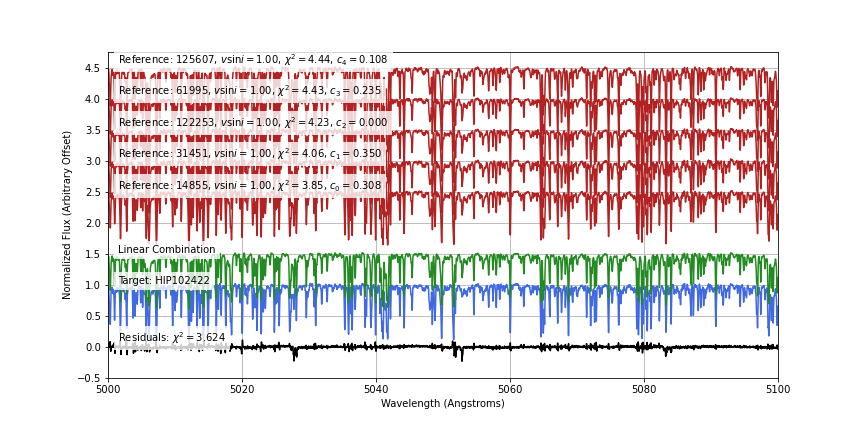

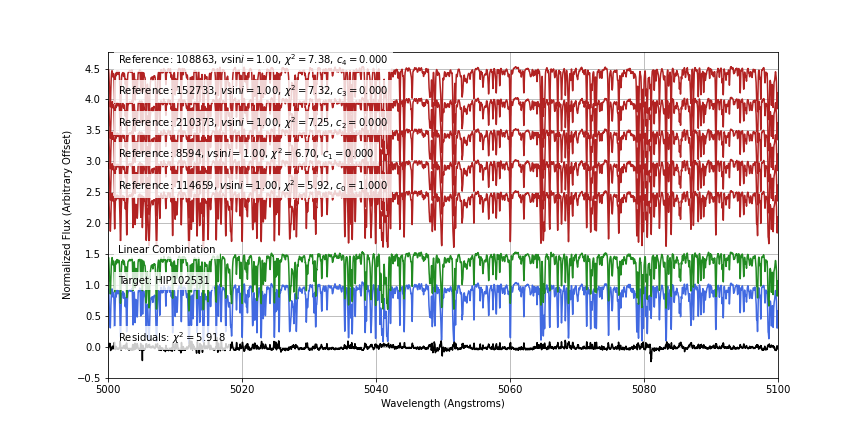

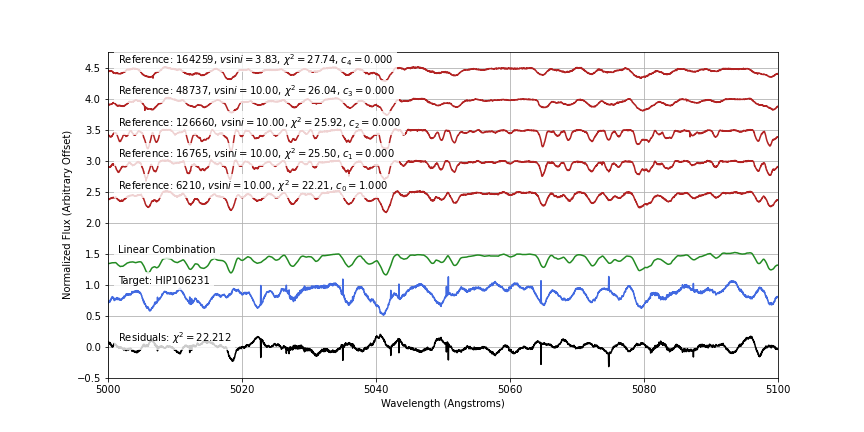

<Figure size 1080x1080 with 0 Axes>

In [621]:
from IPython.core.display import Image, display
plt.figure(figsize = [15,15])
n = len(T_outlier_names)
for file in R_outlier_names:
    try:
        path = r'/mnt_home/azuckerman/BL_APF_DAP/SM_output_plots/Ref_lincomb_spectra/ref_and_lincomb_spectra_' + str(file) + '.png'
        display(Image(filename = path))
    except FileNotFoundError:
        print('Could not find ref_and_lincomb_spectra_' + str(file) + '.png')


In [580]:
c0_T = not_nan_apf*not_nan_gaia_T*in_lib_region_R*in_lib_region_Teff
c0_R = not_nan_apf*not_nan_gaia_R*in_lib_region_R*in_lib_region_Teff
c1 = gaia_Teff < 4500
c2 = gaia_Teff >= 4500
c3 = gaia_R < 1.0
c4 = gaia_R >= 1.0


RMSE_Teff = np.sqrt(np.mean((diff_T[c0_T*c4])**2))
print('Teff: ')
print('    ' + str(RMSE_Teff))
RMSE_R_R = np.sqrt(np.mean((diff_R[c0_R*c4]/apf_det_R[c0_R*c4])**2))
print('R: ')
print('    ' + str(RMSE_R_R*100))

Teff: 
    304.7909785182723
R: 
    201.97244869538298


In [ ]:
SNR